In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.04.29.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.05.03.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.04.23.csv']

#### Clean df and combine into 1

In [3]:
data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths:
    print(path)
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]
    
data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.04.29.csv
(45777, 14)
(45776, 22) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.05.03.csv
(30294, 14)
(76069, 22) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r3.1m/hardware_test-21.04.23.csv
(47775, 14)
(123839, 22) 



,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
17,041A556020,AM1-9,3.932,2021-04-29 15:38:50.122982400,2021-04-29,29,15:38:50,15,38,50
18,041A556020,AM1-9,3.399,2021-04-29 15:38:56.970009600,2021-04-29,29,15:38:56,15,38,56
19,041A556020,AM1-9,6.068,2021-04-29 15:39:02.086963200,2021-04-29,29,15:39:02,15,39,2
20,041A556020,AM1-9,2.874,2021-04-29 15:39:09.426988800,2021-04-29,29,15:39:09,15,39,9
21,041A556020,AM1-9,0.215,2021-04-29 15:39:14.114966400,2021-04-29,29,15:39:14,15,39,14


In [4]:
data_RFID['IdRFID'].value_counts()

041A555452    26378
041A555BA0    13299
041A556020    13006
041A5552FB    12551
041A555BF5    11785
041A55565D    11393
041A555A69    10610
041A555302    9709 
041A55543F    7656 
041A555EFB    7451 
441A555EFB    1    
Name: IdRFID, dtype: int64

In [5]:
data_RFID = data_RFID[data_RFID['IdRFID'] != '441A555EFB']

#### Compute endtime 

In [6]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(123838, 12)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
17,041A556020,AM1-9,3.932,2021-04-29 15:38:50.122982400,2021-04-29,29,15:38:50,15,38,50,2021-04-29 15:38:54.054982400,15:38:54
18,041A556020,AM1-9,3.399,2021-04-29 15:38:56.970009600,2021-04-29,29,15:38:56,15,38,56,2021-04-29 15:39:00.369009600,15:39:00
19,041A556020,AM1-9,6.068,2021-04-29 15:39:02.086963200,2021-04-29,29,15:39:02,15,39,2,2021-04-29 15:39:08.154963200,15:39:08
20,041A556020,AM1-9,2.874,2021-04-29 15:39:09.426988800,2021-04-29,29,15:39:09,15,39,9,2021-04-29 15:39:12.300988800,15:39:12
21,041A556020,AM1-9,0.215,2021-04-29 15:39:14.114966400,2021-04-29,29,15:39:14,15,39,14,2021-04-29 15:39:14.329966400,15:39:14


#### Add next column (do for each unitLabel separately)

In [7]:
#column for if next is same Id
def next_compare(a, b):
    if a == b:
        compare = 'same'
        
    if a != b:
        compare = 'diff'

    return compare

data_RFID_next = pd.DataFrame()

for unitlabel in data_RFID['unitLabel'].unique():
    print(unitlabel)

    data_int = data_RFID[data_RFID['unitLabel'] == unitlabel].sort_values(['RFID_datetime_start'])
    data_int['RFID_datetime_start_next'] = data_int['RFID_datetime_start'].shift(-1)
    data_int['IdRFID_next'] = data_int['IdRFID'].shift(-1)
    
    data_int['IdRFID_diff_next'] = data_int.apply(lambda row: next_compare(row['IdRFID'], row['IdRFID_next']), axis=1)

    if data_RFID_next.empty:
        data_RFID_next = data_int
    else:
        data_RFID_next = pd.concat([data_RFID_next, data_int], axis=0)

data_RFID_next['time_diff_next'] = (data_RFID_next['RFID_datetime_start_next'] - data_RFID_next['RFID_datetime_end'])
data_RFID_next['time_diff_next'] = [x.total_seconds() for x in data_RFID_next['time_diff_next']]
data_RFID_next['time_diff_next_round'] = data_RFID_next['time_diff_next'].round(-1)
data_RFID_next.head()

AM1-9
AM1-7
AM1-6
AM1-8
AM1-15
AM1-16
AM1-10
AM1-5
AM1-4
AM1-14
AM1-13
AM1-2
AM1-3
AM1-12
AM1-11
AM1-1


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round
27,041A555BF5,AM1-9,0.075,2021-04-23 17:28:51.321964800,2021-04-23,23,17:28:51,17,28,51,2021-04-23 17:28:51.396964800,17:28:51,2021-04-23 17:28:53.035968000,041A555BF5,same,1.639003,0.0
28,041A555BF5,AM1-9,1.374,2021-04-23 17:28:53.035968000,2021-04-23,23,17:28:53,17,28,53,2021-04-23 17:28:54.409968000,17:28:54,2021-04-23 17:30:17.522985600,041A5552FB,diff,83.113017,80.0
31,041A5552FB,AM1-9,1.944,2021-04-23 17:30:17.522985600,2021-04-23,23,17:30:17,17,30,17,2021-04-23 17:30:19.466985600,17:30:19,2021-04-23 17:35:14.876016000,041A555BF5,diff,295.409030,300.0
54,041A555BF5,AM1-9,1.975,2021-04-23 17:35:14.876016000,2021-04-23,23,17:35:14,17,35,14,2021-04-23 17:35:16.851016000,17:35:16,2021-04-23 17:40:17.959008000,041A555A69,diff,301.107992,300.0
104,041A555A69,AM1-9,0.229,2021-04-23 17:40:17.959008000,2021-04-23,23,17:40:17,17,40,17,2021-04-23 17:40:18.188008000,17:40:18,2021-04-23 17:40:55.102022400,041A555BF5,diff,36.914014,40.0


#### Add day, hour, and min counts

In [8]:
#column of running day count
dat_map = dict(zip(data_RFID_next['RFID_date'].unique(), np.arange(1,len(data_RFID_next['RFID_date'].unique())+1)))
data_RFID_next['RFID_day_count'] = data_RFID_next['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID_next['RFID_min_count'] = (data_RFID_next['RFID_hour']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count'] = (data_RFID_next['RFID_min_count']*60) + data_RFID_next['RFID_second'] 

#column of running hour and minute count across all days
data_RFID_next['RFID_hour_count_running'] = (data_RFID_next['RFID_day_count']*24) + data_RFID_next['RFID_hour'] - 24
data_RFID_next['RFID_min_count_running'] = (data_RFID_next['RFID_hour_count_running']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count_running'] = (data_RFID_next['RFID_min_count_running']*60) + data_RFID_next['RFID_second'] - 60

print(data_RFID_next.shape)
data_RFID_next.head()

(123838, 23)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
27,041A555BF5,AM1-9,0.075,2021-04-23 17:28:51.321964800,2021-04-23,23,17:28:51,17,28,51,2021-04-23 17:28:51.396964800,17:28:51,2021-04-23 17:28:53.035968000,041A555BF5,same,1.639003,0.0,1,1048,62931,17,1048,62871
28,041A555BF5,AM1-9,1.374,2021-04-23 17:28:53.035968000,2021-04-23,23,17:28:53,17,28,53,2021-04-23 17:28:54.409968000,17:28:54,2021-04-23 17:30:17.522985600,041A5552FB,diff,83.113017,80.0,1,1048,62933,17,1048,62873
31,041A5552FB,AM1-9,1.944,2021-04-23 17:30:17.522985600,2021-04-23,23,17:30:17,17,30,17,2021-04-23 17:30:19.466985600,17:30:19,2021-04-23 17:35:14.876016000,041A555BF5,diff,295.409030,300.0,1,1050,63017,17,1050,62957
54,041A555BF5,AM1-9,1.975,2021-04-23 17:35:14.876016000,2021-04-23,23,17:35:14,17,35,14,2021-04-23 17:35:16.851016000,17:35:16,2021-04-23 17:40:17.959008000,041A555A69,diff,301.107992,300.0,1,1055,63314,17,1055,63254
104,041A555A69,AM1-9,0.229,2021-04-23 17:40:17.959008000,2021-04-23,23,17:40:17,17,40,17,2021-04-23 17:40:18.188008000,17:40:18,2021-04-23 17:40:55.102022400,041A555BF5,diff,36.914014,40.0,1,1060,63617,17,1060,63557


#### Add light dark

In [9]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID_next['ld_seg'] = data_RFID_next['RFID_hour'].apply(assign_ld)

print(data_RFID_next.shape)
data_RFID_next.head()


(123838, 24)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
27,041A555BF5,AM1-9,0.075,2021-04-23 17:28:51.321964800,2021-04-23,23,17:28:51,17,28,51,2021-04-23 17:28:51.396964800,17:28:51,2021-04-23 17:28:53.035968000,041A555BF5,same,1.639003,0.0,1,1048,62931,17,1048,62871,light
28,041A555BF5,AM1-9,1.374,2021-04-23 17:28:53.035968000,2021-04-23,23,17:28:53,17,28,53,2021-04-23 17:28:54.409968000,17:28:54,2021-04-23 17:30:17.522985600,041A5552FB,diff,83.113017,80.0,1,1048,62933,17,1048,62873,light
31,041A5552FB,AM1-9,1.944,2021-04-23 17:30:17.522985600,2021-04-23,23,17:30:17,17,30,17,2021-04-23 17:30:19.466985600,17:30:19,2021-04-23 17:35:14.876016000,041A555BF5,diff,295.409030,300.0,1,1050,63017,17,1050,62957,light
54,041A555BF5,AM1-9,1.975,2021-04-23 17:35:14.876016000,2021-04-23,23,17:35:14,17,35,14,2021-04-23 17:35:16.851016000,17:35:16,2021-04-23 17:40:17.959008000,041A555A69,diff,301.107992,300.0,1,1055,63314,17,1055,63254,light
104,041A555A69,AM1-9,0.229,2021-04-23 17:40:17.959008000,2021-04-23,23,17:40:17,17,40,17,2021-04-23 17:40:18.188008000,17:40:18,2021-04-23 17:40:55.102022400,041A555BF5,diff,36.914014,40.0,1,1060,63617,17,1060,63557,light


#### Add day/night mapping (lines up dates and ld segments)

In [10]:
ld_mapping_path = '/Users/abbieschindler/Documents/ProgrammingFun/iPythonScripts/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(89, 3)


,day,ld_seg,ld
0,2,dark_am,dark_night1
1,3,dark_am,dark_night2
2,4,dark_am,dark_night3
3,5,dark_am,dark_night4
4,6,dark_am,dark_night5


In [11]:
data_RFID_next = data_RFID_next.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID_next.shape)
data_RFID_next.head()

(123838, 26)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld
0,041A555BF5,AM1-9,0.075,2021-04-23 17:28:51.321964800,2021-04-23,23,17:28:51,17,28,51,2021-04-23 17:28:51.396964800,17:28:51,2021-04-23 17:28:53.035968000,041A555BF5,same,1.639003,0.0,1,1048,62931,17,1048,62871,light,1,light_day1
1,041A555BF5,AM1-9,1.374,2021-04-23 17:28:53.035968000,2021-04-23,23,17:28:53,17,28,53,2021-04-23 17:28:54.409968000,17:28:54,2021-04-23 17:30:17.522985600,041A5552FB,diff,83.113017,80.0,1,1048,62933,17,1048,62873,light,1,light_day1
2,041A5552FB,AM1-9,1.944,2021-04-23 17:30:17.522985600,2021-04-23,23,17:30:17,17,30,17,2021-04-23 17:30:19.466985600,17:30:19,2021-04-23 17:35:14.876016000,041A555BF5,diff,295.409030,300.0,1,1050,63017,17,1050,62957,light,1,light_day1
3,041A555BF5,AM1-9,1.975,2021-04-23 17:35:14.876016000,2021-04-23,23,17:35:14,17,35,14,2021-04-23 17:35:16.851016000,17:35:16,2021-04-23 17:40:17.959008000,041A555A69,diff,301.107992,300.0,1,1055,63314,17,1055,63254,light,1,light_day1
4,041A555A69,AM1-9,0.229,2021-04-23 17:40:17.959008000,2021-04-23,23,17:40:17,17,40,17,2021-04-23 17:40:18.188008000,17:40:18,2021-04-23 17:40:55.102022400,041A555BF5,diff,36.914014,40.0,1,1060,63617,17,1060,63557,light,1,light_day1


#### Map unitLabel and bottle contents

In [12]:
unitLabel_map = {'AM1-1': 'RFID_EtOH10',
                 'AM1-2': 'RFID_EtOH05',
                 'AM1-3': 'RFID_EtOH20',
                 'AM1-4': 'RFID_H20',
                 'AM1-5': 'RFID_EtOH10',
                 'AM1-6': 'RFID_EtOH05',
                 'AM1-7': 'RFID_EtOH20',
                 'AM1-8': 'RFID_H20',
                 'AM1-9': 'RFID_EtOH10',
                 'AM1-10': 'RFID_EtOH05',
                 'AM1-11': 'RFID_EtOH20',
                 'AM1-12': 'RFID_H20',
                 'AM1-13': 'RFID_EtOH10',
                 'AM1-14': 'RFID_EtOH05',
                 'AM1-15': 'RFID_EtOH20',
                 'AM1-16': 'RFID_H20',}

data_RFID_next['unitLabel_drink'] = data_RFID_next['unitLabel'].map(unitLabel_map)
print(data_RFID_next.shape)

(123838, 27)


#### Add metadata and clean

In [13]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID_meta_data.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID_next.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(123838, 43)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld,unitLabel_drink
0,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,108,AM1-5,2.403,2021-04-23 17:24:58.542998400,2021-04-23,23,17:24:58,17,24,58,2021-04-23 17:25:00.945998400,17:25:00,2021-04-23 17:25:18.859958400,041A555EFB,diff,17.913960,20.0,1,1044,62698,17,1044,62638,light,1,light_day1,RFID_EtOH10
1,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,133,AM1-4,0.542,2021-04-23 17:36:14.483030399,2021-04-23,23,17:36:14,17,36,14,2021-04-23 17:36:15.025030399,17:36:15,2021-04-23 17:37:05.738966400,041A555EFB,diff,50.713936,50.0,1,1056,63374,17,1056,63314,light,1,light_day1,RFID_H20
2,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,137,AM1-4,0.368,2021-04-23 17:43:02.380022400,2021-04-23,23,17:43:02,17,43,2,2021-04-23 17:43:02.748022400,17:43:02,2021-04-23 17:43:52.825008000,041A555EFB,diff,50.076985,50.0,1,1063,63782,17,1063,63722,light,1,light_day1,RFID_H20
3,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,139,AM1-4,4.690,2021-04-23 17:44:20.804956800,2021-04-23,23,17:44:20,17,44,20,2021-04-23 17:44:25.494956800,17:44:25,2021-04-23 17:44:55.470019200,041A555EFB,diff,29.975062,30.0,1,1064,63860,17,1064,63800,light,1,light_day1,RFID_H20
4,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,144,AM1-4,6.470,2021-04-23 17:49:28.114032000,2021-04-23,23,17:49:28,17,49,28,2021-04-23 17:49:34.584032000,17:49:34,2021-04-23 17:50:29.397984000,041A555EFB,diff,54.813952,50.0,1,1069,64168,17,1069,64108,light,1,light_day1,RFID_H20


In [14]:
data_RFID_final = data_RFID_final[['Round', 'Round_info', 'Timepoint', 'Cage_N', 'Cage', 'Animal',
                                   'Injury', 'IdRFID', 'weight_pre', 'weight_post', 'weight_diff', 
                                   'notes', 'wes_day', 'wd_day', 'r_day',
                                   'unitLabel', 'unitLabel_drink', 'eventDuration',
                                   'RFID_datetime_start', 'RFID_datetime_end',
                                   'RFID_datetime_start_next', 'IdRFID_next', 
                                   'IdRFID_diff_next', 'time_diff_next', 'time_diff_next_round', 
                                   'RFID_time_start', 'RFID_time_end',
                                   'RFID_date', 'RFID_day', 'ld', 'ld_seg', 'RFID_day_count',
                                   'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_min_count', 'RFID_sec_count',
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running']]

print(data_RFID_final.shape)
data_RFID_final.head()

(123838, 40)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,etoh2,post_LPD,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,AM1-5,RFID_EtOH10,2.403,2021-04-23 17:24:58.542998400,2021-04-23 17:25:00.945998400,2021-04-23 17:25:18.859958400,041A555EFB,diff,17.913960,20.0,17:24:58,17:25:00,2021-04-23,23,light_day1,light,1,17,24,58,1044,62698,17,1044,62638
1,etoh2,post_LPD,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,AM1-4,RFID_H20,0.542,2021-04-23 17:36:14.483030399,2021-04-23 17:36:15.025030399,2021-04-23 17:37:05.738966400,041A555EFB,diff,50.713936,50.0,17:36:14,17:36:15,2021-04-23,23,light_day1,light,1,17,36,14,1056,63374,17,1056,63314
2,etoh2,post_LPD,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,AM1-4,RFID_H20,0.368,2021-04-23 17:43:02.380022400,2021-04-23 17:43:02.748022400,2021-04-23 17:43:52.825008000,041A555EFB,diff,50.076985,50.0,17:43:02,17:43:02,2021-04-23,23,light_day1,light,1,17,43,2,1063,63782,17,1063,63722
3,etoh2,post_LPD,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,AM1-4,RFID_H20,4.690,2021-04-23 17:44:20.804956800,2021-04-23 17:44:25.494956800,2021-04-23 17:44:55.470019200,041A555EFB,diff,29.975062,30.0,17:44:20,17:44:25,2021-04-23,23,light_day1,light,1,17,44,20,1064,63860,17,1064,63800
4,etoh2,post_LPD,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,AM1-4,RFID_H20,6.470,2021-04-23 17:49:28.114032000,2021-04-23 17:49:34.584032000,2021-04-23 17:50:29.397984000,041A555EFB,diff,54.813952,50.0,17:49:28,17:49:34,2021-04-23,23,light_day1,light,1,17,49,28,1069,64168,17,1069,64108


#### Viz

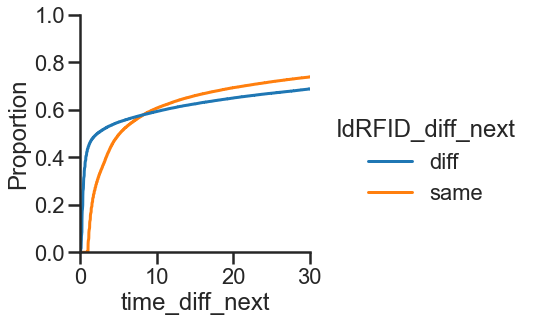

In [20]:
data_int = data_RFID_final[data_RFID_final['time_diff_next'] < 600]
sns.displot(data=data_RFID_final, x="time_diff_next", hue="IdRFID_diff_next", kind="ecdf")
plt.xlim(0, 30)
plt.show()

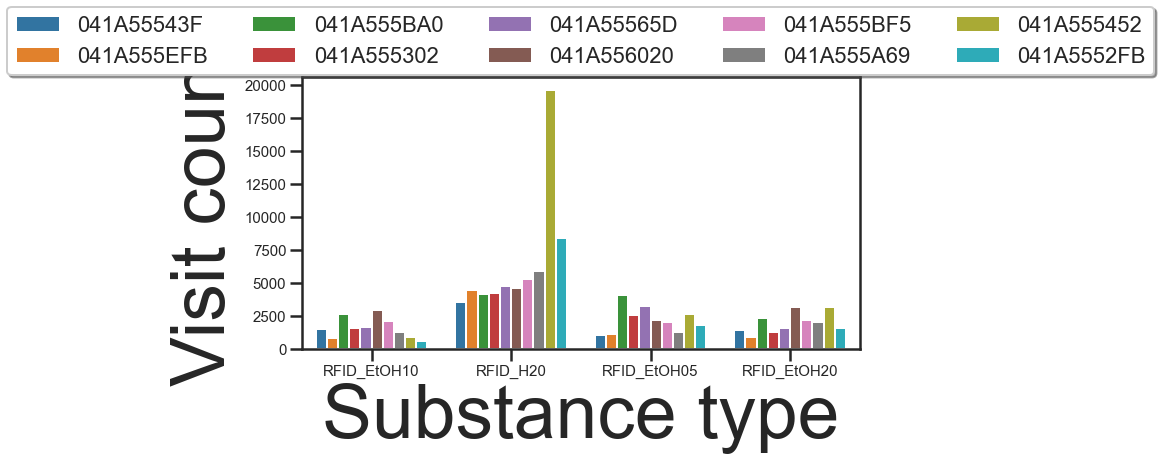

In [34]:
data_int = data_RFID_final[data_RFID_final['RFID_day_count'] >5]
plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.countplot(data=data_RFID_final, x="unitLabel_drink", hue="IdRFID")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

In [26]:
data_RFID_final.groupby(['Injury'])['unitLabel_drink'].unique()

Injury
blast    [RFID_EtOH20, RFID_EtOH05, RFID_H20, RFID_EtOH10]
sham     [RFID_EtOH10, RFID_H20, RFID_EtOH05, RFID_EtOH20]
Name: unitLabel_drink, dtype: object

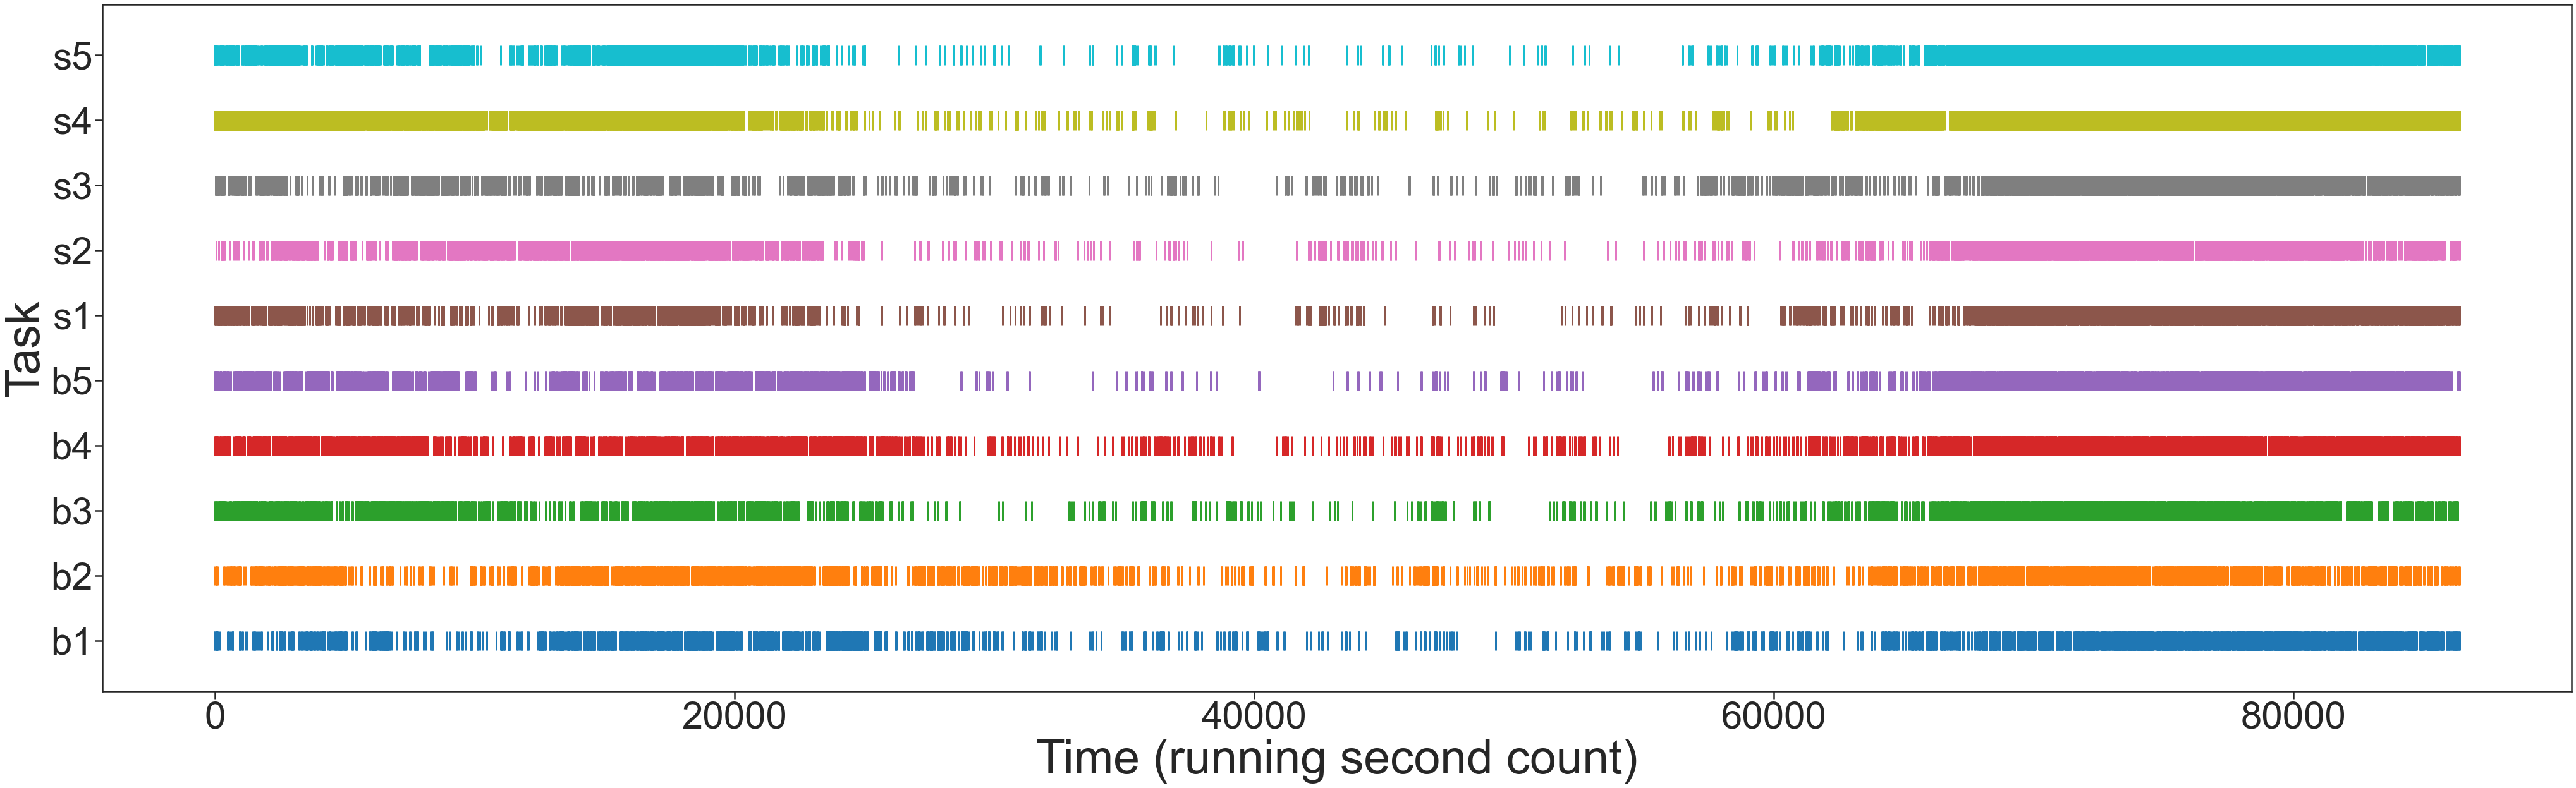

In [27]:
data_ul1 = data_RFID_final[data_RFID_final['unitLabel_drink'] == 'RFID_H20']
#data_ul12 = data_ul1[data_ul1['ld'] == 'light_day3']
data_ul12 = data_ul1
colorCodes = ['C{}'.format(i) for i in range(10)]

param = 'RFID_sec_count'

data_1 = data_ul12[data_ul12['IdRFID'] == '041A55543F'][param].values
data_2 = data_ul12[data_ul12['IdRFID'] == '041A555EFB'][param].values
data_3 = data_ul12[data_ul12['IdRFID'] == '041A556020'][param].values
data_4 = data_ul12[data_ul12['IdRFID'] == '041A555BF5'][param].values
data_5 = data_ul12[data_ul12['IdRFID'] == '041A555A69'][param].values
data_6 = data_ul12[data_ul12['IdRFID'] == '041A555BA0'][param].values
data_7 = data_ul12[data_ul12['IdRFID'] == '041A555302'][param].values
data_8 = data_ul12[data_ul12['IdRFID'] == '041A55565D'][param].values
data_9 = data_ul12[data_ul12['IdRFID'] == '041A555452'][param].values
data_10 = data_ul12[data_ul12['IdRFID'] == '041A5552FB'][param].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5,
                      data_6, data_7, data_8, data_9, data_10,
                      ])

# Draw a spike raster plot
plt.figure(figsize=(70,20))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=60) 
plt.rc('ytick', labelsize=60) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4,5,6,7,8,9,], 
           ['b1', 'b2', 'b3', 'b4', 'b5', 
            's1', 's2', 's3', 's4', 's5', 
            ])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)')
plt.ylabel('Task')


plt.show()

### VDM data

#### Make and clean df

In [35]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210423.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210429.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210503.csv']

In [36]:
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[18].values
    data_VDM_int = data_VDM_int.drop([18])
    
    data_VDM_int['Cohort'] = path.split('/')[-2].split('.')[0]
    data_VDM_int['TP'] = path.split('/')[-2].split('.')[1]
    data_VDM_int['StartDate'] = path.split('/')[-1].split('.')[0]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210423.csv
(1284131, 15) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210429.csv
(2093851, 15) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r3.1m/210503.csv
(2745235, 15) 

(2745235, 15)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,Cohort,TP,StartDate
19,0,1,04/23/21 17:37:14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r3,1m,210423
20,0,2,04/23/21 17:37:14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r3,1m,210423
21,0,3,04/23/21 17:37:14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r3,1m,210423
22,0,4,04/23/21 17:37:14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r3,1m,210423
23,1,1,04/23/21 17:37:15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r3,1m,210423


#### Clean up column names

In [37]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_EtOH10', 'VDM_EtOH10_accum',
                    'VDM_EtOH05', 'VDM_EtOH05_accum', 
                    'VDM_EtOH20', 'VDM_EtOH20_accum', 
                    'VDM_H20', 'VDM_H20_accum', '',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 'VDM_EtOH05', 'VDM_EtOH10', 'VDM_EtOH20', 'VDM_H20']]

data_VDM.tail()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20,VDM_H20
651398,4,r3,1m,210503,05/06/21 09:23:10,0.000,0.000,0.000,0.000
651399,1,r3,1m,210503,05/06/21 09:23:11,0.000,0.000,0.000,0.000
651400,2,r3,1m,210503,05/06/21 09:23:11,0.000,0.000,0.000,0.000
651401,3,r3,1m,210503,05/06/21 09:23:11,0.000,0.000,0.000,0.000
651402,4,r3,1m,210503,05/06/21 09:23:11,0.000,0.000,0.000,0.000


#### Convert liquid vol to etoh vol

In [38]:
data_VDM['VDM_EtOH10'] = data_VDM['VDM_EtOH10'].astype('float')
data_VDM['VDM_EtOH20'] = data_VDM['VDM_EtOH20'].astype('float')
data_VDM['VDM_EtOH05'] = data_VDM['VDM_EtOH05'].astype('float')
data_VDM['VDM_H20'] = data_VDM['VDM_H20'].astype('float')

#### Make into tidy df

In [39]:
#melt dataframe (new column of parameters)

meta_params = ['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time']
intake_params = ['VDM_EtOH05', 'VDM_EtOH10', 'VDM_EtOH20', 'VDM_H20']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(10980940, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
0,1,r3,1m,210423,04/23/21 17:37:14,VDM_EtOH05,0.0
1,2,r3,1m,210423,04/23/21 17:37:14,VDM_EtOH05,0.0
2,3,r3,1m,210423,04/23/21 17:37:14,VDM_EtOH05,0.0
3,4,r3,1m,210423,04/23/21 17:37:14,VDM_EtOH05,0.0
4,1,r3,1m,210423,04/23/21 17:37:15,VDM_EtOH05,0.0


#### Drop times with no intake data

In [40]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(21413, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
28442,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021
38405,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021
41056,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022
49635,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025
49663,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025


#### Clean up datetime

In [41]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(21413, 15)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
28442,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021,2021-04-23 20:46:09,1.619211e+09,2021-04-23,23,20:46:09,20,46,9
38405,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021,2021-04-23 21:52:14,1.619215e+09,2021-04-23,23,21:52:14,21,52,14
41056,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022,2021-04-23 22:09:50,1.619216e+09,2021-04-23,23,22:09:50,22,9,50
49635,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025,2021-04-23 23:06:45,1.619219e+09,2021-04-23,23,23:06:45,23,6,45
49663,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025,2021-04-23 23:06:56,1.619219e+09,2021-04-23,23,23:06:56,23,6,56


#### Add light dark and clean

In [42]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
28442,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021,2021-04-23 20:46:09,1.619211e+09,2021-04-23,23,20:46:09,20,46,9,dark_pm
38405,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021,2021-04-23 21:52:14,1.619215e+09,2021-04-23,23,21:52:14,21,52,14,dark_pm
41056,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022,2021-04-23 22:09:50,1.619216e+09,2021-04-23,23,22:09:50,22,9,50,dark_pm
49635,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025,2021-04-23 23:06:45,1.619219e+09,2021-04-23,23,23:06:45,23,6,45,dark_pm
49663,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025,2021-04-23 23:06:56,1.619219e+09,2021-04-23,23,23:06:56,23,6,56,dark_pm


### Filter RFID data by VDM times

In [43]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['variable', 'VDM_datetime']).reset_index(drop=True)
data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
0,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021,2021-04-23 20:46:09,1.619211e+09,2021-04-23,23,20:46:09,20,46,9,dark_pm
1,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021,2021-04-23 21:52:14,1.619215e+09,2021-04-23,23,21:52:14,21,52,14,dark_pm
2,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022,2021-04-23 22:09:50,1.619216e+09,2021-04-23,23,22:09:50,22,9,50,dark_pm
3,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025,2021-04-23 23:06:45,1.619219e+09,2021-04-23,23,23:06:45,23,6,45,dark_pm
4,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025,2021-04-23 23:06:56,1.619219e+09,2021-04-23,23,23:06:56,23,6,56,dark_pm


In [44]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
data_RFID_final.head()

,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,etoh2,post_LPD,1,2,1,1229,sham,041A555EFB,31.1,NaN,NaN,NaN,NaT,7.0,11.0,AM1-2,RFID_EtOH05,2.660,2021-04-23 17:28:42.254025599,2021-04-23 17:28:44.914025599,2021-04-23 17:32:16.225008000,041A555EFB,same,211.310982,210.0,17:28:42,17:28:44,2021-04-23,23,light_day1,light,1,17,28,42,1048,62922,17,1048,62862
1,etoh2,post_LPD,1,3,3,1232,sham,041A556020,32.0,NaN,NaN,NaN,NaT,7.0,11.0,AM1-10,RFID_EtOH05,1.673,2021-04-23 17:29:12.268003200,2021-04-23 17:29:13.941003200,2021-04-23 17:32:01.052044800,041A555452,diff,167.111041,170.0,17:29:12,17:29:13,2021-04-23,23,light_day1,light,1,17,29,12,1049,62952,17,1049,62892
2,etoh2,post_LPD,1,2,4,1250,blast,041A555452,30.4,NaN,NaN,NaN,NaT,7.0,11.0,AM1-10,RFID_EtOH05,3.204,2021-04-23 17:32:01.052044800,2021-04-23 17:32:04.256044800,2021-04-23 17:32:34.470009600,041A555A69,diff,30.213964,30.0,17:32:01,17:32:04,2021-04-23,23,light_day1,light,1,17,32,1,1052,63121,17,1052,63061
3,etoh2,post_LPD,1,3,2,1244,blast,041A555BA0,32.4,NaN,NaN,NaN,NaT,7.0,11.0,AM1-6,RFID_EtOH05,6.252,2021-04-23 17:32:09.560975999,2021-04-23 17:32:15.812975999,2021-04-23 17:33:50.814000000,041A555302,diff,95.001024,100.0,17:32:09,17:32:15,2021-04-23,23,light_day1,light,1,17,32,9,1052,63129,17,1052,63069
4,etoh2,post_LPD,1,2,1,1229,sham,041A555EFB,31.1,NaN,NaN,NaN,NaT,7.0,11.0,AM1-2,RFID_EtOH05,7.095,2021-04-23 17:32:16.225008000,2021-04-23 17:32:23.320008000,2021-04-23 17:34:30.432979200,041A555EFB,same,127.112971,130.0,17:32:16,17:32:23,2021-04-23,23,light_day1,light,1,17,32,16,1052,63136,17,1052,63076


In [45]:
data_comb = data_VDM_tidy_intake
RFID_data = data_RFID_final

VDM_RFID_mapping = {'VDM_EtOH10': 'RFID_EtOH10',
                    'VDM_EtOH05': 'RFID_EtOH05',
                    'VDM_EtOH20': 'RFID_EtOH20',
                    'VDM_H20': 'RFID_H20'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []
RFID_datetime_start_next = []
IdRFID_next = []
IdRFID_diff_next = []
time_diff_next = []
ld = []

for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = RFID_data[(RFID_data['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (RFID_data['unitLabel_drink'] == VDM_RFID_mapping[row['variable']]) & #match tube
                               (RFID_data['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])
        RFID_datetime_start_next.append(int_assign['RFID_datetime_start_next'])
        IdRFID_next.append(int_assign['IdRFID_next'])
        IdRFID_diff_next.append(int_assign['IdRFID_diff_next'])
        time_diff_next.append(int_assign['time_diff_next'])
        ld.append(int_assign['ld'])
        
    except:
        print(index, 'pre')
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)
        RFID_datetime_start_next.append(np.nan)
        IdRFID_next.append(np.nan)
        IdRFID_diff_next.append(np.nan)
        time_diff_next.append(np.nan)
        ld.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre
data_comb['RFID_datetime_start_next'] = RFID_datetime_start_next
data_comb['IdRFID_next'] = IdRFID_next
data_comb['IdRFID_diff_next'] = IdRFID_diff_next
data_comb['time_diff_next'] = time_diff_next
data_comb['ld'] = ld

print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
(21413, 26)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld
0,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021,2021-04-23 20:46:09,1.619211e+09,2021-04-23,23,20:46:09,20,46,9,dark_pm,0.872,041A5552FB,AM1-14,2021-04-23 20:37:18.715987200,2021-04-23 20:37:19.587987200,2021-04-23 20:52:36.783984000,041A555452,diff,917.195996,dark_night1
1,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021,2021-04-23 21:52:14,1.619215e+09,2021-04-23,23,21:52:14,21,52,14,dark_pm,1.603,041A556020,AM1-10,2021-04-23 21:50:16.969977600,2021-04-23 21:50:18.572977600,2021-04-23 21:52:39.984009600,041A555A69,diff,141.411032,dark_night1
2,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022,2021-04-23 22:09:50,1.619216e+09,2021-04-23,23,22:09:50,22,9,50,dark_pm,1.545,041A555BA0,AM1-6,2021-04-23 22:09:40.286966400,2021-04-23 22:09:41.831966400,2021-04-23 22:22:27.028992000,041A555BA0,same,765.197025,dark_night1
3,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025,2021-04-23 23:06:45,1.619219e+09,2021-04-23,23,23:06:45,23,6,45,dark_pm,5.865,041A555EFB,AM1-2,2021-04-23 23:06:41.752972800,2021-04-23 23:06:47.617972800,2021-04-23 23:06:51.432019200,041A555EFB,same,3.814046,dark_night1
4,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025,2021-04-23 23:06:56,1.619219e+09,2021-04-23,23,23:06:56,23,6,56,dark_pm,7.126,041A555EFB,AM1-2,2021-04-23 23:06:52.745990400,2021-04-23 23:06:59.871990400,2021-04-23 23:07:07.287024000,041A555EFB,same,7.415033,dark_night1


In [46]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff
0,4,r3,1m,210423,04/23/21 20:46:09,VDM_EtOH05,0.021,2021-04-23 20:46:09,1.619211e+09,2021-04-23,23,20:46:09,20,46,9,dark_pm,0.872,041A5552FB,AM1-14,2021-04-23 20:37:18.715987200,2021-04-23 20:37:19.587987200,2021-04-23 20:52:36.783984000,041A555452,diff,917.195996,dark_night1,529.412012
1,3,r3,1m,210423,04/23/21 21:52:14,VDM_EtOH05,0.021,2021-04-23 21:52:14,1.619215e+09,2021-04-23,23,21:52:14,21,52,14,dark_pm,1.603,041A556020,AM1-10,2021-04-23 21:50:16.969977600,2021-04-23 21:50:18.572977600,2021-04-23 21:52:39.984009600,041A555A69,diff,141.411032,dark_night1,115.427022
2,2,r3,1m,210423,04/23/21 22:09:50,VDM_EtOH05,0.022,2021-04-23 22:09:50,1.619216e+09,2021-04-23,23,22:09:50,22,9,50,dark_pm,1.545,041A555BA0,AM1-6,2021-04-23 22:09:40.286966400,2021-04-23 22:09:41.831966400,2021-04-23 22:22:27.028992000,041A555BA0,same,765.197025,dark_night1,8.168033
3,1,r3,1m,210423,04/23/21 23:06:45,VDM_EtOH05,0.025,2021-04-23 23:06:45,1.619219e+09,2021-04-23,23,23:06:45,23,6,45,dark_pm,5.865,041A555EFB,AM1-2,2021-04-23 23:06:41.752972800,2021-04-23 23:06:47.617972800,2021-04-23 23:06:51.432019200,041A555EFB,same,3.814046,dark_night1,0.000000
4,1,r3,1m,210423,04/23/21 23:06:56,VDM_EtOH05,0.025,2021-04-23 23:06:56,1.619219e+09,2021-04-23,23,23:06:56,23,6,56,dark_pm,7.126,041A555EFB,AM1-2,2021-04-23 23:06:52.745990400,2021-04-23 23:06:59.871990400,2021-04-23 23:07:07.287024000,041A555EFB,same,7.415033,dark_night1,0.000000


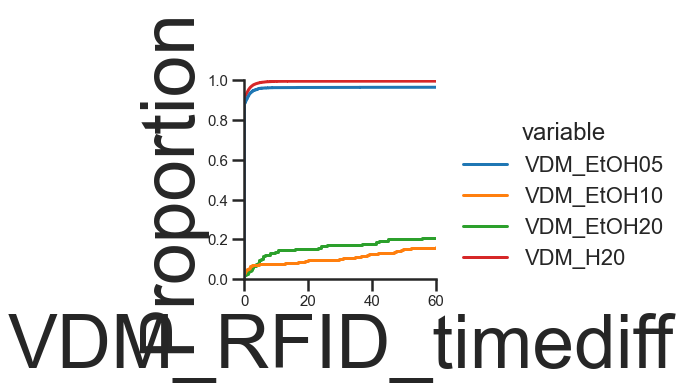

In [52]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='variable')
plt.xlim(0, 60)
plt.show()

#### Add metadata

In [48]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(21413, 44)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff
0,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,56,1,r3,1m,210423,04/24/21 19:44:15,VDM_EtOH05,0.025,2021-04-24 19:44:15,1.619293e+09,2021-04-24,24,19:44:15,19,44,15,dark_pm,5.986,041A55543F,AM1-2,2021-04-24 18:24:41.467017600,2021-04-24 18:24:47.453017600,2021-04-24 19:53:46.770979200,041A555EFB,diff,5339.317961,dark_night2,4767.546982
1,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,63,1,r3,1m,210423,04/25/21 03:48:00,VDM_EtOH05,0.025,2021-04-25 03:48:00,1.619322e+09,2021-04-25,25,03:48:00,3,48,0,dark_am,4.165,041A55543F,AM1-2,2021-04-25 03:46:04.392969600,2021-04-25 03:46:08.557969600,2021-04-25 03:51:33.377990400,041A555EFB,diff,324.820020,dark_night2,111.442030
2,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,67,1,r3,1m,210423,04/25/21 11:10:42,VDM_EtOH05,0.025,2021-04-25 11:10:42,1.619349e+09,2021-04-25,25,11:10:42,11,10,42,light,2.862,041A55543F,AM1-2,2021-04-25 10:09:51.511968000,2021-04-25 10:09:54.373968000,2021-04-25 12:40:37.826025600,041A555EFB,diff,9043.452057,light_day3,3647.626032
3,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,72,1,r3,1m,210423,04/25/21 19:20:14,VDM_EtOH05,0.025,2021-04-25 19:20:14,1.619378e+09,2021-04-25,25,19:20:14,19,20,14,dark_pm,1.056,041A55543F,AM1-2,2021-04-25 19:18:40.542019200,2021-04-25 19:18:41.598019200,2021-04-25 19:30:37.470038400,041A55543F,same,715.872019,dark_night3,92.401980
4,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,79,1,r3,1m,210423,04/26/21 04:11:09,VDM_EtOH05,0.025,2021-04-26 04:11:09,1.619410e+09,2021-04-26,26,04:11:09,4,11,9,dark_am,3.549,041A55543F,AM1-2,2021-04-26 04:02:52.971964800,2021-04-26 04:02:56.520964800,2021-04-26 04:11:37.025030400,041A55543F,same,520.504065,dark_night3,492.479035


#### Add day, hour, and min counts

In [53]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['day_count'] = data_comb['VDM_day'].map(dat_map)

#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

print(data_comb.shape)
data_comb.head()

(21413, 56)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,VDM_RFID_timediff,VDM_day_count,VDM_min_count,VDM_second_count,VDM_hour_count_running,VDM_min_count_running,VDM_second_count_running,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,56,1,r3,1m,210423,04/24/21 19:44:15,VDM_EtOH05,0.025,2021-04-24 19:44:15,1.619293e+09,2021-04-24,24,19:44:15,19,44,15,dark_pm,5.986,041A55543F,AM1-2,2021-04-24 18:24:41.467017600,2021-04-24 18:24:47.453017600,2021-04-24 19:53:46.770979200,041A555EFB,diff,5339.317961,dark_night2,4767.546982,1,1184,71055,19,1184,70995,NaN,1184,71055,NaN,NaN,NaN
1,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,63,1,r3,1m,210423,04/25/21 03:48:00,VDM_EtOH05,0.025,2021-04-25 03:48:00,1.619322e+09,2021-04-25,25,03:48:00,3,48,0,dark_am,4.165,041A55543F,AM1-2,2021-04-25 03:46:04.392969600,2021-04-25 03:46:08.557969600,2021-04-25 03:51:33.377990400,041A555EFB,diff,324.820020,dark_night2,111.442030,2,228,13680,27,1668,100020,NaN,228,13680,NaN,NaN,NaN
2,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,67,1,r3,1m,210423,04/25/21 11:10:42,VDM_EtOH05,0.025,2021-04-25 11:10:42,1.619349e+09,2021-04-25,25,11:10:42,11,10,42,light,2.862,041A55543F,AM1-2,2021-04-25 10:09:51.511968000,2021-04-25 10:09:54.373968000,2021-04-25 12:40:37.826025600,041A555EFB,diff,9043.452057,light_day3,3647.626032,2,670,40242,35,2110,126582,NaN,670,40242,NaN,NaN,NaN
3,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,72,1,r3,1m,210423,04/25/21 19:20:14,VDM_EtOH05,0.025,2021-04-25 19:20:14,1.619378e+09,2021-04-25,25,19:20:14,19,20,14,dark_pm,1.056,041A55543F,AM1-2,2021-04-25 19:18:40.542019200,2021-04-25 19:18:41.598019200,2021-04-25 19:30:37.470038400,041A55543F,same,715.872019,dark_night3,92.401980,2,1160,69614,43,2600,155954,NaN,1160,69614,NaN,NaN,NaN
4,etoh2,post_LPD,1,1,2,1,1227,sham,041A55543F,29.6,NaN,NaN,NaN,NaT,7.0,11.0,79,1,r3,1m,210423,04/26/21 04:11:09,VDM_EtOH05,0.025,2021-04-26 04:11:09,1.619410e+09,2021-04-26,26,04:11:09,4,11,9,dark_am,3.549,041A55543F,AM1-2,2021-04-26 04:02:52.971964800,2021-04-26 04:02:56.520964800,2021-04-26 04:11:37.025030400,041A55543F,same,520.504065,dark_night3,492.479035,3,251,15069,52,3131,187809,NaN,251,15069,NaN,NaN,NaN


### Export data

In [54]:
data_RFID_final.to_csv('data_RFID_final_1m_r2.csv')
data_comb.to_csv('data_comb_1m_r2.csv')